# Example of using the ieinn library with Google Colaboratory
By using Google Colaboratory (hereinafter referred to as Google Colab), you can easily set up a Python execution environment. You can also use a GPU for free. Here, we will introduce an example of using the ieinn library with Google Colab.
## First, mount Google Drive and download the ieinn library to your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
!git clone https://github.com/AoiHonda-lab/IEI-NeuralNetwork.git

fatal: destination path 'IEI-NeuralNetwork' already exists and is not an empty directory.


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/IEI-NeuralNetwork/ieinn")

In [ ]:
%cd /content/drive/MyDrive/IEI-NeuralNetwork

/content/drive/MyDrive/IEI-NeuralNetwork


## Import the necessary libraries.

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import csv
from sklearn.model_selection import train_test_split
from ieinn import ieinn

If a GPU is available, set the device to "cuda"; otherwise, set it to "cpu".

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## Data Loading
Perform data loading and processing tasks such as reading the data and splitting it into training and validation datasets.

In [ ]:
df=pd.read_csv('CarEvaluation20221207.csv',encoding="shift-jis")
df=df.drop(0,axis=0)
df=df.astype(float)

y=pd.DataFrame(df.iloc[:,0])
X=pd.DataFrame(df.iloc[:,1:])

#Normalize the objective variable
y=(y - y.min()) / (y.max() - y.min())

# data Generating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_df=X_train
y_train_df=y_train

# Extract as a numpy array with value and convert to tensor
X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values)

In [ ]:
print(df)

          price  carat  cut  color  clarity
1      0.000000   0.21  4.0    6.0      3.0
2      0.000054   0.23  2.0    6.0      5.0
3      0.000433   0.29  4.0    2.0      4.0
4      0.000487   0.31  2.0    1.0      2.0
5      0.000541   0.24  3.0    1.0      6.0
...         ...    ...  ...    ...      ...
53902  0.131427   0.72  5.0    7.0      3.0
53903  0.131427   0.72  2.0    7.0      3.0
53904  0.131427   0.70  3.0    7.0      3.0
53905  0.131427   0.86  4.0    3.0      2.0
53906  0.131427   0.75  5.0    7.0      2.0

[53906 rows x 5 columns]


## Create Dataset and DataLoader
Create datasets for training and testing data, and use them as arguments to create data loaders. Specify the mini-batch size and whether to shuffle the data.

In [ ]:
# Dataset creating
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# DataLoade creating
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=2, generator=torch.Generator(device=device))
#train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=2, generator=torch.Generator(device=device))
#test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False, num_workers=2)

## Creating the Training Model
Create the model using the IE class from the imported ieinn library. Pass the following arguments: the training data loader, the degree of additivity for fuzzy measures, the polynomial operation used for integration, and the type of preprocessing.

For the training data loader, use the previously created train_loader. The degree of additivity should be an integer ranging from 1 to the number of explanatory variables. For operations, t-norms such as logical product (Min), algebraic product (Algebraic), and bounded product (Lukasiewicz) are available. Preprocessing options include PreprocessingLayerPercentile, PreprocessingLayerStandardDeviation, and PreprocessingLayerMaxMin. If you don't specify the degree of additivity, operations, or preprocessing method, the defaults will be set as complete non-additivity, algebraic product, and PreprocessingLayerPercentile, respectively.

In [ ]:
model=ieinn.IE(train_loader,additivity_order=4,narray_op='Algebraic', preprocessing='PreprocessingLayerStandardDeviation').to(device)
criterion = nn.MSELoss() #loss function
optimizer = torch.optim.Adam(model.parameters()) #Optimization method
print(model)\\Adobe Acrobat.lnk

IE(
  (preprocessing1): PreprocessingLayerStandardDeviation()
  (preprocessing2): PreprocessingLayerStandardDeviation()
  (preprocessing3): PreprocessingLayerStandardDeviation()
  (preprocessing4): PreprocessingLayerStandardDeviation()
  (iei): Algebraic()
  (output): OutputLayer()
)


## Check the parameters before training.

In [ ]:
model.state_dict()

OrderedDict([('preprocessing1.weight', tensor([[0.8922]])),
             ('preprocessing1.bias', tensor([-0.7130])),
             ('preprocessing2.weight', tensor([[2.0908]])),
             ('preprocessing2.bias', tensor([-8.1569])),
             ('preprocessing3.weight', tensor([[3.1894]])),
             ('preprocessing3.bias', tensor([-14.0794])),
             ('preprocessing4.weight', tensor([[3.0817]])),
             ('preprocessing4.bias', tensor([-12.4829])),
             ('output.weight',
              tensor([[0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
                       0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])),
             ('output.bias', tensor([0.]))])

## Execute the training.

In [ ]:
if (device == 'cuda'):
  torch.set_default_tensor_type('torch.cuda.FloatTensor')
history=model.fit_and_valid(train_loader, test_loader, criterion, optimizer, epochs=300, device=device)

Epoch [1/300], train_loss: 0.04138199 val_loss: 0.02060910
Epoch [2/300], train_loss: 0.01123447 val_loss: 0.00579593
Epoch [3/300], train_loss: 0.00493955 val_loss: 0.00397709
Epoch [4/300], train_loss: 0.00366900 val_loss: 0.00323352
Epoch [5/300], train_loss: 0.00311220 val_loss: 0.00294127
Epoch [6/300], train_loss: 0.00284393 val_loss: 0.00267936
Epoch [7/300], train_loss: 0.00268363 val_loss: 0.00255851
Epoch [8/300], train_loss: 0.00259470 val_loss: 0.00246409
Epoch [9/300], train_loss: 0.00252548 val_loss: 0.00240683
Epoch [10/300], train_loss: 0.00247720 val_loss: 0.00236557
Epoch [11/300], train_loss: 0.00244410 val_loss: 0.00233047
Epoch [12/300], train_loss: 0.00241676 val_loss: 0.00233015
Epoch [13/300], train_loss: 0.00239640 val_loss: 0.00232036
Epoch [14/300], train_loss: 0.00238646 val_loss: 0.00231066
Epoch [15/300], train_loss: 0.00236578 val_loss: 0.00227032
Epoch [16/300], train_loss: 0.00235605 val_loss: 0.00225136
Epoch [17/300], train_loss: 0.00234914 val_loss: 

## Displaying the Training Results
Display the coefficient of determination, parameters, and learning curve after training.

In [ ]:
model.r2_score(test_loader,device)

0.9708990873953354

In [ ]:
model.state_dict()

OrderedDict([('preprocessing1.weight', tensor([[1.9121]])),
             ('preprocessing1.bias', tensor([-3.2185])),
             ('preprocessing2.weight', tensor([[3.4346]])),
             ('preprocessing2.bias', tensor([-6.1333])),
             ('preprocessing3.weight', tensor([[0.8613]])),
             ('preprocessing3.bias', tensor([-3.0814])),
             ('preprocessing4.weight', tensor([[0.4282]])),
             ('preprocessing4.bias', tensor([-1.3187])),
             ('output.weight',
              tensor([[ 0.4439,  0.0182,  0.0634, -0.0257,  0.4095, -0.6119,  0.9769, -0.0295,
                       -0.0208, -0.1646, -0.4312, -0.5722,  2.4537, -0.0070,  1.2795]])),
             ('output.bias', tensor([-0.0572]))])

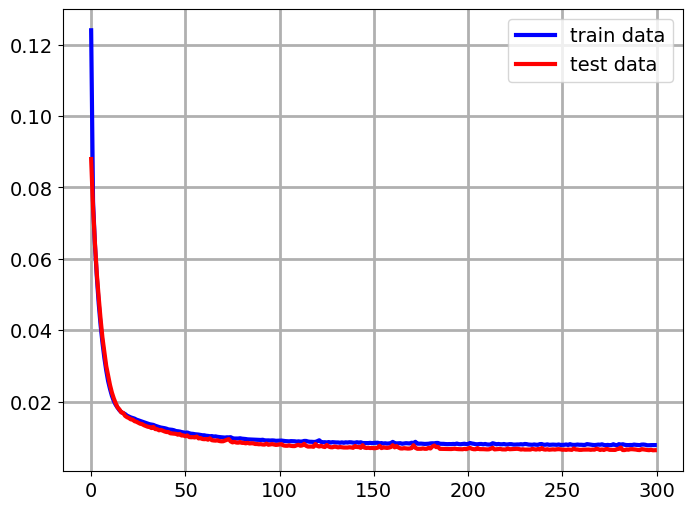

0

In [ ]:
model.plot()

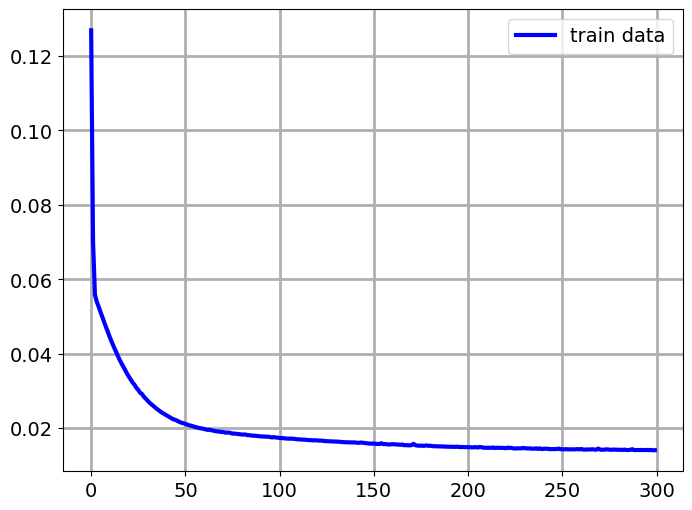

0

In [ ]:
model.plot_train()

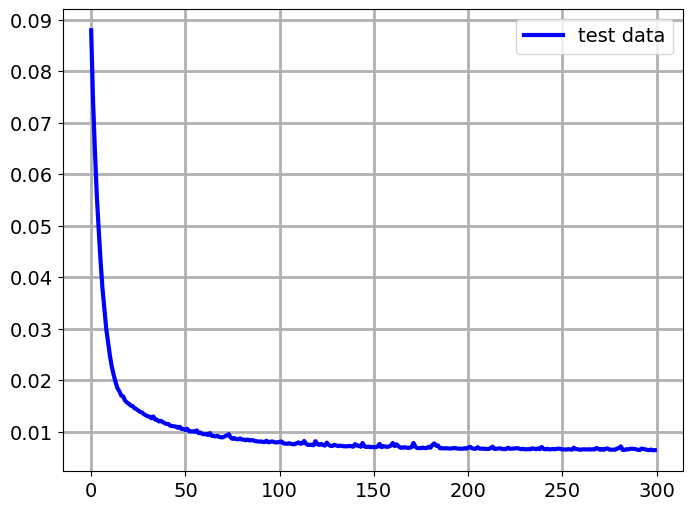

0

In [ ]:
model.plot_test()